<a href="https://colab.research.google.com/github/LucianoTrujillo/7506R-2C2022-GRUPO10/blob/main/7506R_TP1_GRUPO10_ENTREGA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#**TP1: Propiedades en Venta**



---


---


## *Facultad de Ingeniería, Universidad de Buenos Aires*

---
### *2do Cuatrimestre de 2022*

---
### *Organización de Datos*

### *Curso: Rodriguez*

### *Integrantes:*

* Luciano Leon Trujillo Palomo ltrujillo@fi.uba.ar 105664
* María Pilar Gaddi mgaddi@fi.uba.ar 105682
* Federico Adrian Solari Vazquez fsolariv@fi.uba.ar 106895
* Maria Vazquez Navarro mvazquezn@fi.uba.ar 105576
* Mateo Bulnes mbulnes@fi.uba.ar 106211
---

## **Objetivo del trabajo**

---
---

El objetivo de la siguiente investigación es comparar:

* bla

---





# Preprocesamiento de Datos

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm 

url='https://drive.google.com/file/d/1z05Y6UwTu8fz1DpeE4JlRoyjJx_vPKmM/view'
file_id=url.split('/')[-2]
dwn_url='https://drive.google.com/uc?id=' + file_id

df = pd.read_csv(dwn_url, iterator=True)
df = pd.concat(df, ignore_index=True)
df.head(20)

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,place_l5,place_l6,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title
0,XZq2dFGxBiboHY3Bo/tqlw==,2021-09-09,2022-01-27,2021-09-09,-38.957632,-68.105443,Neuquén,NaN,NaN,NaN,NaN,Venta,Casa,6.0,NaN,NaN,206.0,NaN,NaN,Casa - Capital
1,8afoK+yMH/rnnlYiktwgNA==,2021-09-09,2021-10-23,2021-09-09,-34.888878,-56.092368,Montevideo,NaN,NaN,NaN,NaN,Venta,Casa,4.0,3.0,193.0,193.0,390000.0,USD,Casa - Malvín
2,iVaG5rBB47dd1Ya4BMXREA==,2021-09-09,2022-03-09,2021-09-09,-32.488717,-58.257499,Entre Ríos,NaN,NaN,NaN,NaN,Venta,Casa,NaN,NaN,110.0,45.0,47000.0,USD,Casa - Uruguay
3,QE1QVMWKAHWkd0qT0FtPWA==,2021-09-09,2022-01-27,2021-09-09,-34.900165,-54.808453,Maldonado,NaN,NaN,NaN,NaN,Venta,Casa,NaN,3.0,NaN,180.0,400000.0,USD,Casa - El Chorro
4,tJ5lSk7IysG/71OGhacNZA==,2021-09-09,2022-01-27,2021-09-09,-38.954528,-68.041862,Neuquén,NaN,NaN,NaN,NaN,Venta,PH,3.0,2.0,NaN,98.0,102000.0,USD,PH - Villa Farrell
5,F9tamlHF5c8kGM6XRTsCKQ==,2021-09-09,2022-01-27,2021-09-09,-34.859680,-56.195410,Montevideo,NaN,NaN,NaN,NaN,Venta,Departamento,3.0,2.0,54.0,54.0,189900.0,USD,Apartamento - Prado
6,NqZ7NCaGZKarCdU/V0vHfw==,2021-09-09,2021-09-14,2021-09-09,NaN,NaN,Bs.As. G.B.A. Zona Norte,NaN,NaN,NaN,NaN,Venta,Casa,5.0,3.0,294.0,254.0,249000.0,USD,Casa - Los Cardales
7,gRTl4HxCqiGIwGRq0r1oag==,2021-09-09,2022-01-05,2021-09-09,NaN,NaN,Bs.As. G.B.A. Zona Norte,NaN,NaN,NaN,NaN,Venta,Casa,7.0,3.0,462.0,308.0,460000.0,USD,Casa - Los Cardales
8,Y8n0DpI7wgglQ6QISaTB4g==,2021-09-09,2021-09-10,2021-09-09,-34.901935,-56.183708,Montevideo,NaN,NaN,NaN,NaN,Alquiler,Departamento,5.0,2.0,60.0,60.0,26760.0,UYU,Apartamento - Cordón
9,HMt6tiEI+xILu5W6cjGdiw==,2021-09-09,2021-10-28,2021-09-09,-34.866268,-56.092273,Montevideo,NaN,NaN,NaN,NaN,Alquiler,Casa,5.0,2.0,70.0,70.0,19000.0,UYU,Casa - Carrasco Norte


Primero filtramos por tipo de vivienda:

In [ ]:
ds = df.copy()
ds = ds.query('property_type == "Casa" or property_type == "Departamento" or property_type == "PH"')

Luego filtramos los ubicados en Capital Federal: 

---



In [ ]:
df.query('\
place_l3=="Capital Federal" or \
place_l4=="Capital Federal" or \
place_l5=="Capital Federal" or \
place_l6=="Capital Federal"').size

0

Observamos que la única columna que contiene a la clasificación de Capital Federal es place_l2, con lo cual con filtrar por l2, nos aseguramos de únicamente quedarnos con las filas que cumplan ser de Capital Federal.

In [ ]:
ds = ds.query('place_l2 == "Capital Federal"')

Luego filtramos por tipo de operación (Venta):

In [ ]:
ds = ds.query('operation == "Venta"')

Luego filtramos por moneda (USD):

In [ ]:
ds = ds.query('property_currency == "USD"')
print("Tamaño:", ds.shape)
ds.head(15)

Tamaño: (94249, 20)


,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,place_l5,place_l6,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title
25,CyZu6IaZgmQYGk8jmPajCg==,2021-09-09,2021-09-26,2021-09-09,NaN,NaN,Capital Federal,NaN,NaN,NaN,NaN,Venta,Casa,4.0,3.0,171.0,133.0,210000.0,USD,VENTA CASA LLAVE EN MANO - COSTA ESMERALDA
42,d3Z0MblSb2IMBoOBMGJEEQ==,2021-09-09,2021-09-26,2021-09-09,-34.637319,-58.361124,Capital Federal,Boca,NaN,NaN,NaN,Venta,Departamento,3.0,2.0,58.0,55.0,82900.0,USD,VENTA TRES AMBIENTES LA BOCA PISO ALTO
43,rL7qPkQnomsMGu2ViS3sBw==,2021-09-09,2021-09-28,2021-09-09,-34.628647,-58.361871,Capital Federal,Boca,NaN,NaN,NaN,Venta,Departamento,4.0,3.0,70.0,70.0,99000.0,USD,Departamento - 4 Ambientes - Catalinas Sur
49,vuX/ccLAMVml4qWRFcOJUA==,2021-09-09,2022-01-05,2021-09-09,-34.610027,-58.401934,Capital Federal,Once,NaN,NaN,NaN,Venta,Departamento,4.0,2.0,NaN,104.0,146000.0,USD,Venta departamento 4 ambientes Once
51,ZTtSCeqZ3HUgf5jjwEzRcw==,2021-09-09,2022-03-09,2021-09-09,-34.631621,-58.416825,Capital Federal,Boedo,NaN,NaN,NaN,Venta,PH,4.0,2.0,NaN,73.0,250000.0,USD,PH - Boedo
53,3XhGN1xIqtzxywrDb3vC/w==,2021-09-09,2022-01-27,2021-09-09,-34.623886,-58.412746,Capital Federal,Boedo,NaN,NaN,NaN,Venta,PH,2.0,1.0,61.0,46.0,100000.0,USD,PH 2 Ambientes c/Patio HECHO A NUEVO
55,zIXYgKHTdJ5HFYpZ8oROeQ==,2021-09-09,2021-09-19,2021-09-09,-34.625588,-58.423056,Capital Federal,Boedo,NaN,NaN,NaN,Venta,PH,4.0,2.0,104.0,54.0,185000.0,USD,PH Venta PH 3 ambientes + Patio + Terraza Divino
56,ahcEMvB66wjPz0SYWZQDBw==,2021-09-09,2021-09-26,2021-09-09,-34.629398,-58.425852,Capital Federal,Boedo,NaN,NaN,NaN,Venta,Departamento,2.0,1.0,62.0,44.0,100000.0,USD,VENTA 2 ambientes EN DUPLEX sin Expensas en Boedo
57,M0g0l0s6S13X+cZlGkUo8g==,2021-09-09,2021-09-19,2021-09-09,-34.620748,-58.412004,Capital Federal,Boedo,NaN,NaN,NaN,Venta,Departamento,3.0,2.0,59.0,55.0,185000.0,USD,Venta depto 3 amb Boedo cochera fija y amenities.
58,tgaK6Ibor1zLY5bvNxsXfw==,2021-09-09,2021-09-26,2021-09-09,-34.633730,-58.424729,Capital Federal,Boedo,NaN,NaN,NaN,Venta,Casa,10.0,10.0,394.0,244.0,500000.0,USD,VENTA CASA BOEDO LOCAL DEPARTAMENTOS HABITACI...


## Exploración Inicial

### Clasificación  de variables 

Variables cuantitativas discretas:

- start date, end date, created on: Las fechas pueden ser consideradas cuantitativas discretas dado que toman valores numéricos ordenables, y entre dos valores consecutivos no existen valores intermedios (al menos en nuestro data set). 

- property_rooms, property_bedrooms: Pueden ser consideradas cuantitativas discretas ya que pueden tomar un conjunto a lo sumo numerable de valores, y cuentan cosas.

Variables cuantitativas continuas:

- latitud y longitud:  Estas variables al tomar valores numéricos en los cuales existen infinitos valores intermedios, pueden ser consideradas como continuas. 

- property_surface_total, property_surface_covered, property_price: Al igual que las variables anteriores, estas pueden tomar infinitos valores numéricos intermedios y por esa razón son consideradas continuas. 

Variables cualitativas nominales:

- id: es una variable que representa una identificación, cada una de estas es diferente y no tienen un orden visible. 

- place_l2, place_l3, place_l4: son variables que son diferentes, no son trivialmente ordenables, dado que simplemente son un nombre correspondiente a la ubicación geográfica.

- place_l5, place_l6: según la descripción de las otras columnas de place de properati, estas features también deberían ser de esta clase, pero están vacías.

- operation, property_type, property_currency: son variable que representan características para diferenciar propiedades entre sí, pero al igual que places, no tienen un ordenamiento predefinido. 

In [ ]:
print("l2", ds.place_l2.unique())
print("l3", ds.place_l3.unique())
print("l4", ds.place_l4.unique())
print("l5", ds.place_l5.unique())
print("l6", ds.place_l6.unique())

l2 ['Capital Federal']
l3 [nan 'Boca' 'Once' 'Boedo' 'Flores' 'Nuñez' 'Retiro' 'Almagro' 'Coghlan'
 'Liniers' 'Palermo' 'Pompeya' 'Barracas' 'Belgrano' 'Floresta' 'Recoleta'
 'Saavedra' 'Balvanera' 'Caballito' 'Chacarita' 'Mataderos' 'Monserrat'
 'San Telmo' 'Versalles' 'Agronomía' 'Colegiales' 'Tribunales'
 'Villa Luro' 'Parque Chas' 'Barrio Norte' 'Monte Castro' 'San Nicolás'
 'Villa Crespo' 'Villa Devoto' 'Villa Lugano' 'Constitución'
 'Puerto Madero' 'San Cristobal' 'Villa Ortuzar' 'Villa Urquiza'
 'Velez Sarsfield' 'Parque Chacabuco' 'Parque Patricios'
 'Villa Santa Rita' 'Villa del Parque' 'Parque Avellaneda'
 'Villa Pueyrredón' 'Villa General Mitre' 'Centro / Microcentro'
 'Villa Real' 'Congreso' 'Paternal' 'Abasto' 'Villa Riachuelo'
 'Parque Centenario' 'Villa Soldati' 'Las Cañitas' 'Catalinas']
l4 [nan 'Palermo Chico' 'Palermo Soho' 'Palermo Viejo' 'Palermo Hollywood']
l5 [nan]
l6 [nan]


TODO: Faltan las variables place_l5, place_l6, property_tiltle

### Variables cuantitativas: calcular medidas de resumen

Como debemos calcular la media, mediana, q1, q3 y moda para las variables start_date, end_date, created_on y las mismas son fechas, debemos convertirlas a un tipo de dato adecuado:

In [ ]:
ds_filtrado = ds.copy()
ds_filtrado['start_date']=pd.to_datetime(ds_filtrado['start_date'], errors='ignore')
ds_filtrado['created_on']=pd.to_datetime(ds_filtrado['created_on'], errors='ignore')

In [ ]:
try: 
    pd.to_datetime(ds_datetimes['end_date'])
except Exception as e: print(e)

name 'ds_datetimes' is not defined


Observamos que la columna end_date tiene una row cuyo valor es inválido: "9999-12-31", con lo cual averiguamos cuantos de éstos valores inválidos hay:

In [ ]:
invalid_end_dates = ds_filtrado.end_date[lambda date: pd.isnull(pd.to_datetime(date, errors='coerce'))]
invalid_end_dates.size


5041

Encontramos 5041 apariciones de fecha invalidas. En la sección de Feature Engineering analizaremos que hacer con estos datos. Mientras tanto, hacemos un dataset que no contenga a las fechas inválidas para poder calcularle los valores pedidos.

In [ ]:
ds_end_date = ds_filtrado.copy()
cond_operacion = pd.notnull(pd.to_datetime(ds_end_date['end_date'], errors='coerce'))
ds_end_date = ds_end_date[cond_operacion]
ds_end_date.end_date = pd.to_datetime(ds_end_date['end_date'])

In [ ]:
def mostrar_medidas_resumen(columna, show_boxplot=True, nanpercentile=False, df=ds_filtrado):
    mean=df[columna].mean()

    if(nanpercentile):
        measure_info=np.nanpercentile(df[columna],[25,50,75])
    else:
        measure_info=np.percentile(df[columna],[25,50,75])

    mode=df[columna].mode()

    print(f'Medidas de resumen para la variable {columna}:\n\
    \tMedia: {mean}\n\
    \tq1: {measure_info[0]}\n\
    \tMediana: {measure_info[1]}\n\
    \tq3: {measure_info[2]}\n\
    \tModa: {mode}')

    if(show_boxplot):
        sns.boxplot(y=df[columna])

- start date:

In [ ]:
mostrar_medidas_resumen('start_date', False)

Medidas de resumen para la variable start_date:
    	Media: 2021-07-01 08:38:57.331961344
    	q1: 2021-04-03T00:00:00.000000000
    	Mediana: 2021-06-29T00:00:00.000000000
    	q3: 2021-09-24T00:00:00.000000000
    	Moda: 0   2021-12-16
dtype: datetime64[ns]


- created_on:

In [ ]:
mostrar_medidas_resumen('created_on', False)

Medidas de resumen para la variable created_on:
    	Media: 2021-07-01 08:38:57.331961344
    	q1: 2021-04-03T00:00:00.000000000
    	Mediana: 2021-06-29T00:00:00.000000000
    	q3: 2021-09-24T00:00:00.000000000
    	Moda: 0   2021-12-16
dtype: datetime64[ns]


- end_date:

In [ ]:
mostrar_medidas_resumen('end_date', False, True, ds_end_date)

Medidas de resumen para la variable end_date:
    	Media: 2021-09-14 10:40:09.685230080
    	q1: 2021-06-05T00:00:00.000000000
    	Mediana: 2021-08-30T00:00:00.000000000
    	q3: 2022-01-27T00:00:00.000000000
    	Moda: 0   2021-06-05
dtype: datetime64[ns]


- property_rooms:

Medidas de resumen para la variable property_rooms:
    	Media: 2.8227992060511777
    	q1: 2.0
    	Mediana: 3.0
    	q3: 4.0
    	Moda: 0    3.0
dtype: float64


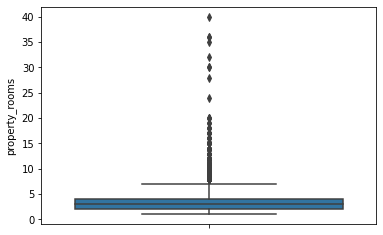

In [ ]:
mostrar_medidas_resumen('property_rooms', True, True)

-  property_bedrooms

Medidas de resumen para la variable property_bedrooms:
    	Media: 2.0146285220148448
    	q1: 1.0
    	Mediana: 2.0
    	q3: 3.0
    	Moda: 0    1.0
dtype: float64


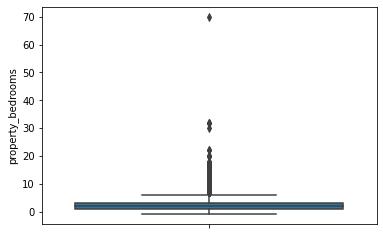

In [ ]:
mostrar_medidas_resumen('property_bedrooms', True, True)

- latitud

Medidas de resumen para la variable latitud:
    	Media: -34.59148102467374
    	q1: -34.6159754
    	Mediana: -34.5957896
    	q3: -34.5774132
    	Moda: 0   -34.54125
dtype: float64


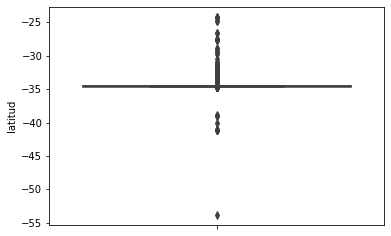

In [ ]:
mostrar_medidas_resumen('latitud', True, True)

- longitud

Medidas de resumen para la variable longitud:
    	Media: -58.449794544855415
    	q1: -58.4665217
    	Mediana: -58.4390004
    	q3: -58.4088623
    	Moda: 0   -58.472966
dtype: float64


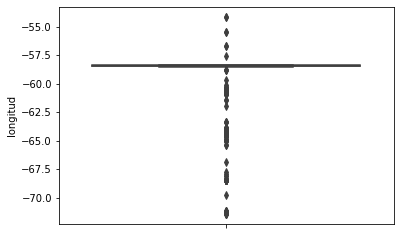

In [ ]:
mostrar_medidas_resumen('longitud', True, True)

- property_surface_total

Medidas de resumen para la variable property_surface_total:
    	Media: 109.09297019182372
    	q1: 45.0
    	Mediana: 65.0
    	q3: 105.0
    	Moda: 0    50.0
dtype: float64


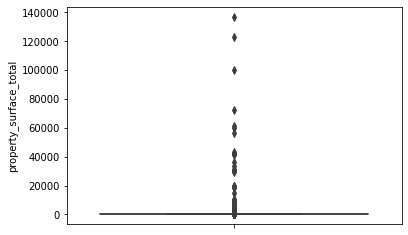

In [ ]:
mostrar_medidas_resumen('property_surface_total', True, True)

- property_surface_covered

In [ ]:
mostrar_medidas_resumen('property_surface_covered', False, True)

Medidas de resumen para la variable property_surface_covered:
    	Media: 87.93193244952968
    	q1: 40.0
    	Mediana: 58.0
    	q3: 88.0
    	Moda: 0    40.0
dtype: float64


- property_price

Medidas de resumen para la variable property_price:
    	Media: 226238.20718522213
    	q1: 95000.0
    	Mediana: 143900.0
    	q3: 237000.0
    	Moda: 0    110000.0
dtype: float64


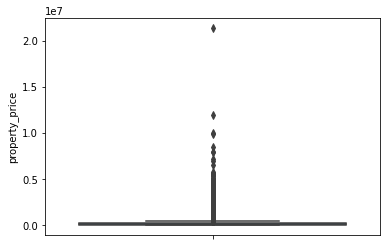

In [ ]:
mostrar_medidas_resumen('property_price', True)

### Variables Cualitativas: cantidad de valores posibles y frecuencias

In [ ]:
def mostrar_frecuencias(columna, ancho=4, alto=4):
    frecuencia_por_valor = ds_filtrado.groupby(columna).size().to_frame("frecuencia")
    frecuencia_por_valor = frecuencia_por_valor.sort_values(by="frecuencia", ascending=False).reset_index()
    frecuencia_por_valor.head(40).plot.bar(x=columna, y="frecuencia", figsize=(ancho, alto))
    plt.show()
    

- place_l2

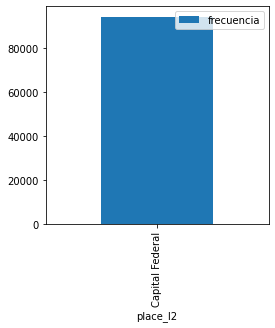

In [ ]:
mostrar_frecuencias('place_l2')

- place_l3

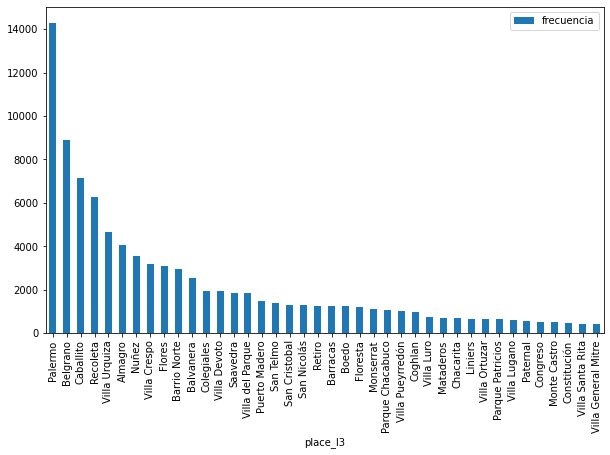

In [ ]:
mostrar_frecuencias('place_l3', 10, 6)

- place_l4

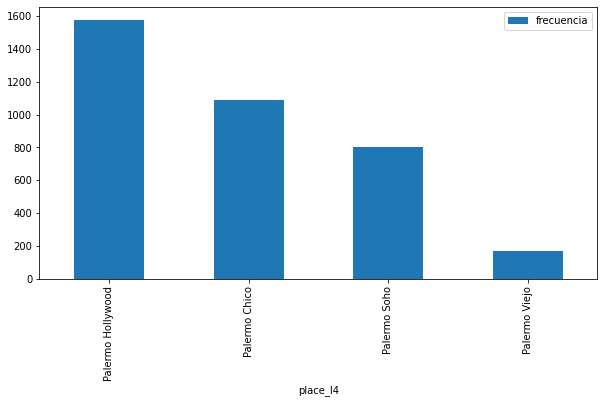

In [ ]:
mostrar_frecuencias('place_l4', 10, 5)

- operation

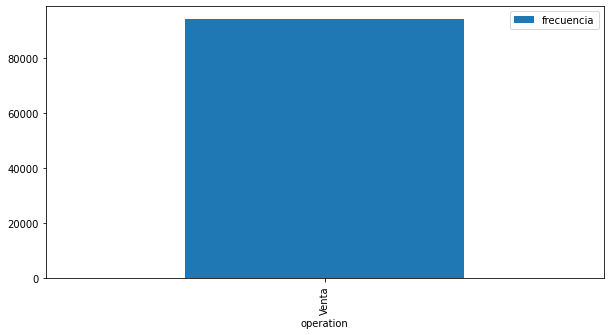

In [ ]:
mostrar_frecuencias('operation', 10, 5)

- property_type

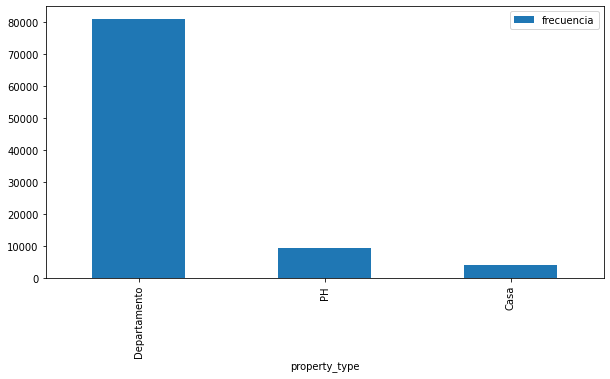

In [ ]:
mostrar_frecuencias('property_type', 10, 5)

- property_currency

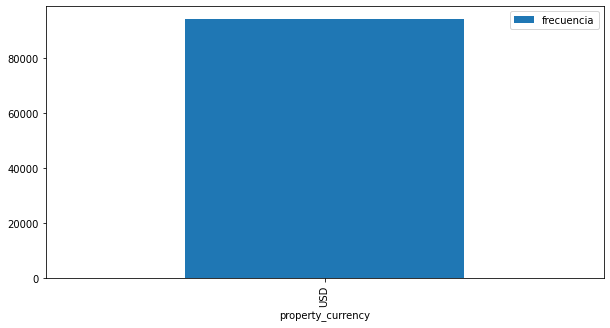

In [ ]:
mostrar_frecuencias('property_currency', 10, 5)

### Variables irrelevantes

Como variables irrelevantes en el análisis tenemos:

- id: El la campo Id es irrelevante ya que no aporta información sobre las viviendas, simplemente es utilizado para guardar la información en la base de datos.

- place_l5, place_l6:  Ambos campos son irrelevantes dado que no poseen datos que brinden información de gran importancia para el dominio del problema (todos los datos son nulos).

- property_title: Dado que no haremos un análisis de NLP, no nos es relevante este campo.

### Análisis gráfico de las distribuciones de las variables cuantitativas

- start_date

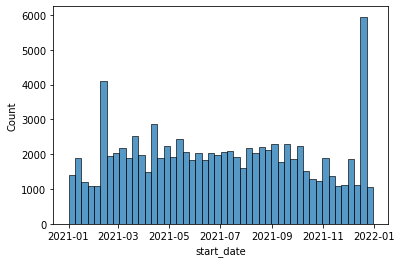

In [ ]:
ds_filtrado.columns
sns.histplot(data=ds_filtrado, x="start_date")

- end_date

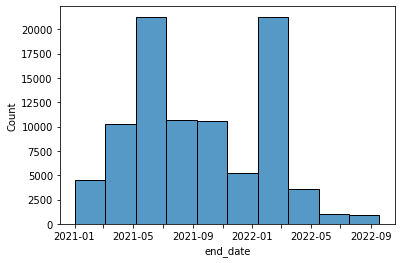

In [ ]:
plot_ = sns.histplot(data=ds_end_date, x="end_date", bins=10)
for ind, label in enumerate(plot_.get_xticklabels()):
    if ind % 2 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)

- created_on

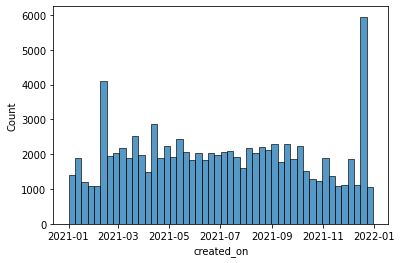

In [ ]:
sns.histplot(data=ds_filtrado, x="created_on")

- property_rooms

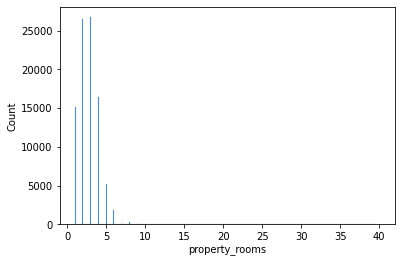

In [ ]:
sns.histplot(data=ds_filtrado, x="property_rooms")

- property_bedrooms

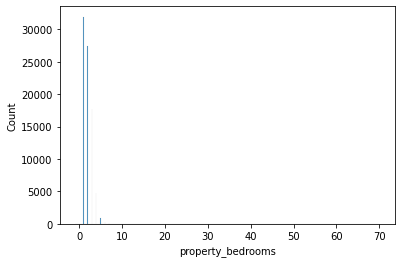

In [ ]:
sns.histplot(data=ds_filtrado, x="property_bedrooms")

- latitud

In [ ]:
#sns.histplot(data=ds_filtrado, x="latitud", y="longitud")

- longitud

In [ ]:
# sns.histplot(data=ds_filtrado, x="longitud")

- property_surface_total

REVISAR, tendría mas sentido que sea continuo el grafico 

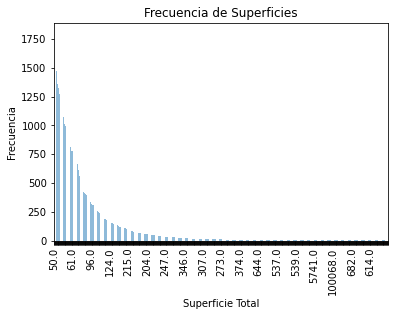

In [ ]:
plot_ = ds_filtrado['property_surface_total'].value_counts().plot.bar(alpha=0.5 , title="Frecuencia de Superficies" , xlabel="Superficie Total" , ylabel="Frecuencia")
#sns.kdeplot(data=ds_filtrado['property_surface_total'])
for ind, label in enumerate(plot_.get_xticklabels()):
    if ind % 40 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)

- property_surface_covered
REVISAR, tendría mas sentido que sea continuo el grafico 

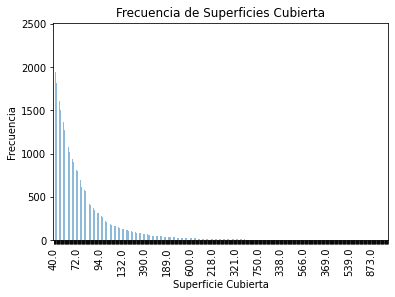

In [ ]:
plot_ = ds_filtrado['property_surface_covered'].value_counts().plot.bar(alpha=0.5 , title="Frecuencia de Superficies Cubierta" , xlabel="Superficie Cubierta" , ylabel="Frecuencia")
for ind, label in enumerate(plot_.get_xticklabels()):
    if ind % 40 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)

- property_price
REVISAR, tendría mas sentido que sea continuo el grafico 

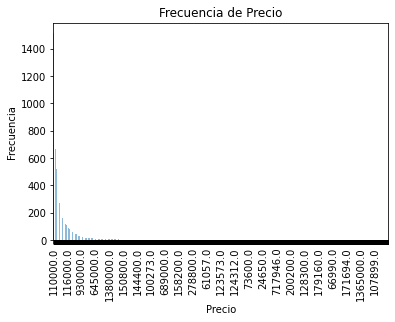

In [ ]:
plot_ = ds_filtrado['property_price'].value_counts().plot.bar(alpha=0.5 , title="Frecuencia de Precio" , xlabel="Precio" , ylabel="Frecuencia")
for ind, label in enumerate(plot_.get_xticklabels()):
    if ind % 200 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)

### Análisis de Correlaciones existentes entre las variables

Eliminamos place_l6 al ser que tratan de elementos de tipo float64, siendo que no son validos como para evaluar correlaciones.

In [ ]:
matriz_temp = ds_filtrado.drop(columns=['place_l6'])
matriz_correlacion = matriz_temp.corr()

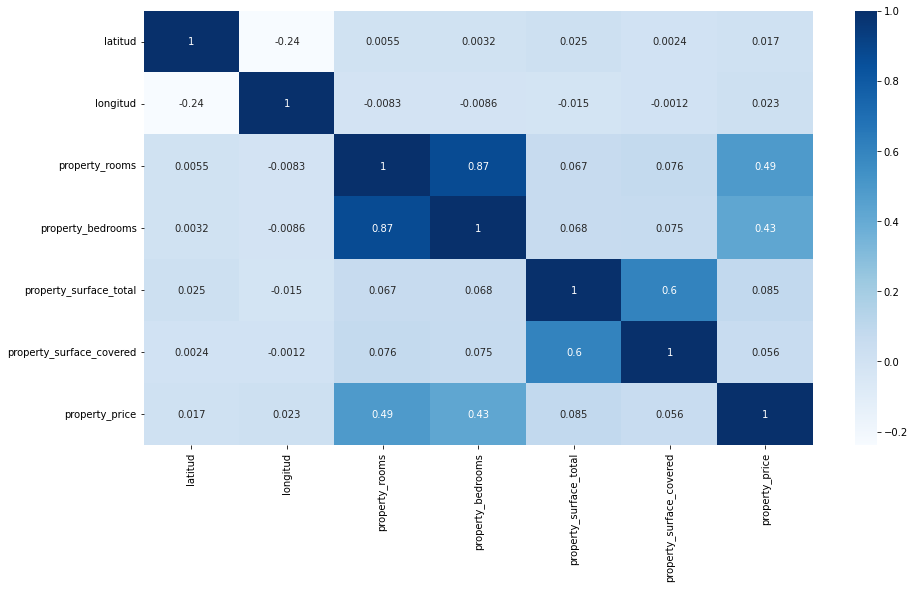

In [ ]:
plt.figure(figsize = (15,8))
sns.heatmap(matriz_correlacion, annot = True, cmap='Blues')

Como observamos del heatmap, hay ciertas variables con una correlación significativa, por ejemplo:

- la cantidad de habitaciones vs la cantidad de ambientes

- superficie cubierta vs superficie total

- precio vs cantidad de ambientes y habitaciones 

Estas relaciones tienen sentido, dado que uno esperaría que a medida aumenta la cantidad de ambientes (y/o cuartos), la propiedad sea mas cara. También tiene mucho sentido que a mas superficie total, se puede tener mas superficie cubierta.

Lo que nos sorprende es que el precio de la propiedad parece tener una correlación muy débil con la superficie total y cubierta, lo cual nos asombra puesto que uno esperaría que a medida que aumentan los m^2 de la propiedad, aumenta su precio. 

### Analisis de Longitud y Latitud

In [ ]:
import json
import shapely
import requests
import random
from shapely.geometry import shape, Point
from shapely.ops import unary_union
from shapely.ops import unary_union



url='https://drive.google.com/file/d/1eeT_53CFY63d55oZo50F7mOKPTZMW--V/view?usp=sharing'
file_id=url.split('/')[-2]
dwn_url='https://drive.google.com/uc?id=' + file_id

url=requests.get(dwn_url)
data=url.text



data=json.loads(data)


caba_barrios = data
barrios = dict(
    (feature["properties"]["BARRIO"], shape(feature["geometry"])) 
    for feature in caba_barrios["features"]
)

all_barrios = unary_union(barrios.values())



def graficar_puntos_en_caba(longitudes, latitudes, tamano_de_punto=4,  proporcion=1):
  lat_long = list(zip(longitudes, latitudes))

  long_min, lat_min, long_max, lat_max = all_barrios.bounds

  viridis = cm.get_cmap('viridis', len(barrios) // 4)
  plasma = cm.get_cmap('plasma', len(barrios) // 4)
  inferno = cm.get_cmap('inferno', len(barrios) // 4)
  cividis = cm.get_cmap('cividis', len(barrios) - (len(barrios) // 4) * 3)
  colors = sum((list(x.colors) for x in (viridis, plasma, inferno, cividis)), [])

  random.shuffle(colors)


  f = plt.figure()
  f.set_figwidth(15)
  f.set_figheight(15)



  for idx, (barrio, shape) in enumerate(barrios.items()):
    for polygon in shape.geoms:
        plt.plot(*polygon.exterior.xy, color=colors[idx])
  
  values=lat_long.copy()
  random.shuffle(values)

  cont_outsiders=0
  cantidad = int(latitudes.size*proporcion)
  for dot in values[:cantidad]:     
    if(all_barrios.contains(Point(dot))):
       plt.scatter(x=dot[0], y=dot[1], s=tamano_de_punto, c='black')
    else: 
      cont_outsiders= cont_outsiders+1
 
  plt.show()
  print("El porcentaje de outsiders dentro de la proporcion pedida de la muestra es:", cont_outsiders/cantidad*100)

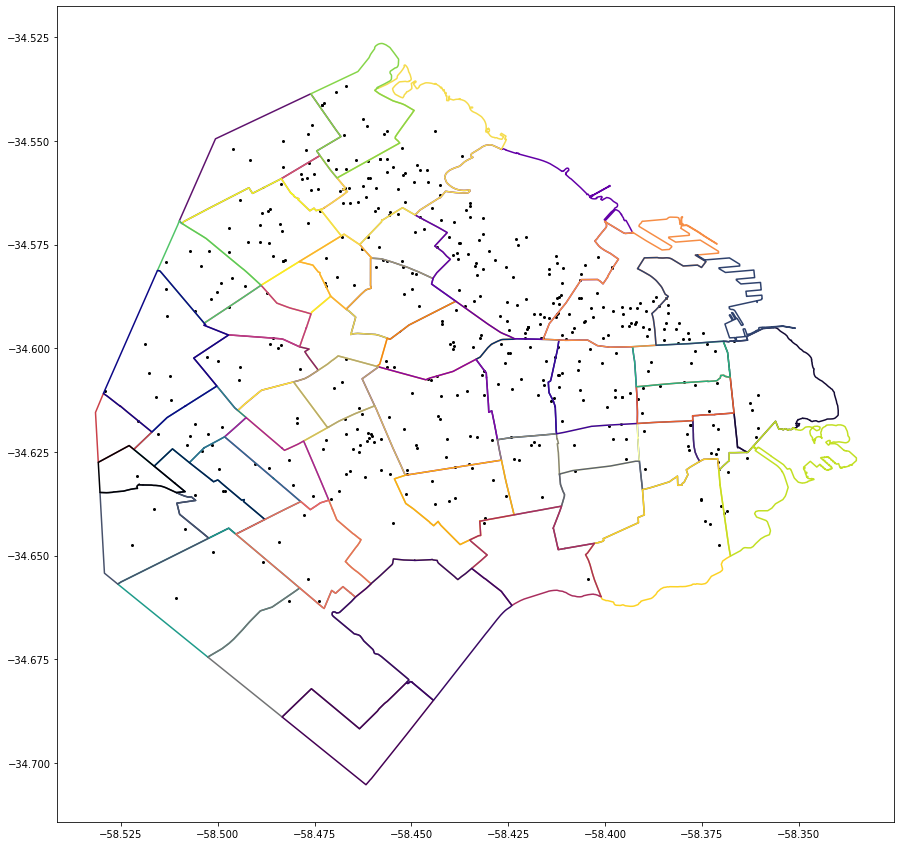

El porcentaje de outsiders dentro de la proporcion pedida de la muestra es: 3.6093418259023355


In [ ]:
graficar_puntos_en_caba(ds_filtrado.longitud, ds_filtrado.latitud, proporcion=0.005)

Como vemos, los puntos se distribuyen de manera coherente con la realidad, donde hay mas densidad de poblacion en sectores populares. Luego analizaremos los puntos faltantes y outsiders por separado, en la secciones correspondientes.   

## Datos Faltantes

### Análisis de datos faltantes a nivel columna

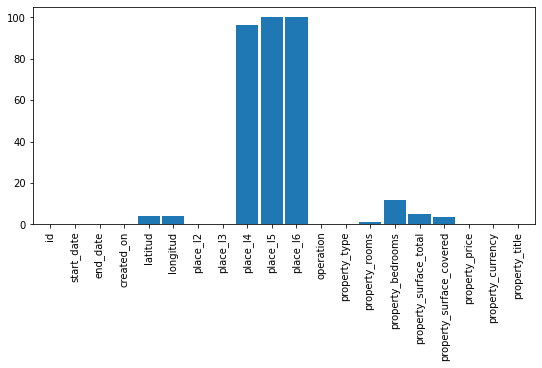

In [ ]:
filas_totales = ds_filtrado.shape[0]
(ds_filtrado.isna().sum()/filas_totales*100).plot( kind = 'bar', 
             stacked = 'True',          # Muestra las barras apiladas
             alpha = 1,                 # nivel de transparencia
             width = 0.9,               # Grosor de las barras para dejar espacio entre ellas
             figsize=(9,4));            # Cambiamos el tamaño de la figura

Observamos que place l4 está conformado mayormente por valores vacíos, mientras que l5 y l6 están completamente vacíos. Luego tenemos varias columnas con todos sus valores, y algunas otras con un porcentaje de valores faltantes relativamente bajo.

### Análisis de datos faltantes a nivel fila

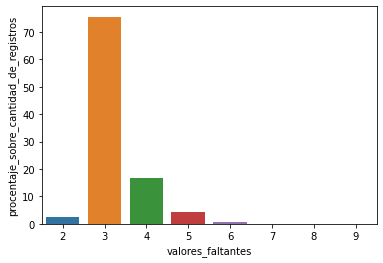

In [ ]:
temp = ds_filtrado.isna().sum(axis=1)
temp = temp.value_counts().to_frame("procentaje_sobre_cantidad_de_registros")
temp['valores_faltantes'] = temp.index
temp = temp.reset_index()
temp.procentaje_sobre_cantidad_de_registros = temp.procentaje_sobre_cantidad_de_registros/filas_totales*100
sns.barplot(data=temp, x="valores_faltantes", y="procentaje_sobre_cantidad_de_registros")
plt.ylabel = "hola"
plt.show()


Podemos observar que contamos con una amplia cantidad de filas con 3 datos faltantes. Se observan pocas filas con mas de 6 datos faltantes, por lo que podemos asumir por ahora que la gran mayoría de nuestro data set nos brinda al menos mas del 50% de información en cada registro. 

### Reparaciones de Datos Faltantes


In [ ]:
(ds_filtrado.isna().sum()/filas_totales*100)

id                            0.000000
start_date                    0.000000
end_date                      0.000000
created_on                    0.000000
latitud                       3.957602
longitud                      3.957602
place_l2                      0.000000
place_l3                      0.442445
place_l4                     96.134707
place_l5                    100.000000
place_l6                    100.000000
operation                     0.000000
property_type                 0.000000
property_rooms                1.107704
property_bedrooms            11.657418
property_surface_total        5.139577
property_surface_covered      3.558658
property_price                0.000000
property_currency             0.000000
property_title                0.000000
dtype: float64

Se observa que las columnas en las que se encuentran datos faltantes son en latitud, longitud, place_l3, place_l4, place_l5, place_l6, property_rooms, property_bedrooms, property_surface_total, y  property_surface_covered.
En esta seccion analizaremos como manejar estos casos especiales. Comenzaremos por la clasificacion de datos faltantes. 

* Missing completly at random:

No existe relacion entre la falta de datos y la variable donde se encuentra el dato faltante.

* Missing not at random:

La falta esta asociada a la naturaleza de la variable. Depende precisamente de los mismos datos que recolectamos. 


* Missing at random: 

La falta no depende de los mismos datos faltantes, sino de otras variables. 


####place_l5 y place_l6

Se observa que place_l5 y place_l6 son datos faltantes de tipo MCAR ya que la razon de falta de datos es ajena a los datos mismos. Faltan datos en todos los registros, por lo que no se puede hacer ninguna relacion entre estos datos y otras columnas.

####place_l4

In [ ]:
print("l4:\n", ds.place_l4.value_counts())
print("\nValores posibles de l4:\n", ds.place_l4.unique())

l4:
 Palermo Hollywood    1576
Palermo Chico        1092
Palermo Soho          804
Palermo Viejo         171
Name: place_l4, dtype: int64

Valores posibles de l4:
 [nan 'Palermo Chico' 'Palermo Soho' 'Palermo Viejo' 'Palermo Hollywood']


Se visualiza que place_l4 solo presenta datos sobre secciones dentro del barrio de Palermo. Si se enlistan los valores posibles en esta variable se aprecia el hecho de que los unicos valores son nan o secciones de Palermo. Por lo que se llega a la conclusion de que los datos faltantes podrian estar relacionados a que dichas celdas no presenten lugares de Palermo. En este caso, se abre la posibilidad de contar con que la variable place_l4 puede contar con datos del tipo MNAR (Missing not at random).  

Text(0.5, 0, 'Place_l3')

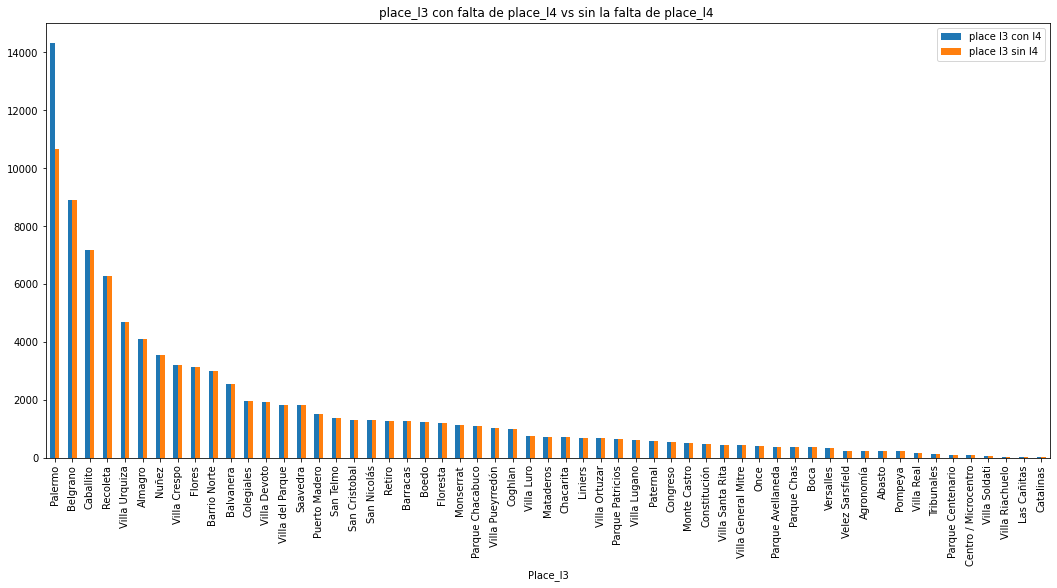

In [ ]:
temp = ds_filtrado[ds_filtrado.place_l4.isna()]

plotdata = pd.DataFrame({
    "place l3 con l4":ds_filtrado.place_l3.value_counts(),
    "place l3 sin l4":temp.place_l3.value_counts(),
    }, 
)
plotdata.plot(kind="bar", figsize=(18,8))
plt.title("place_l3 con falta de place_l4 vs sin la falta de place_l4 ")
plt.xlabel("Place_l3")


Se observa gráficamente que para que se observe un valor no nan en place_l4, place_l3 tiene que ser Palermo. Dado que vemos que aunque place_l3 sea palermo hay un gran procentaje donde falta place_l4, el hecho de que place_l3 sea Palermo es una condición necesaria pero no suficiente para observar place_l4 no nan.


####property_bedrooms


In [ ]:
cond_habitaciones_nan = ds_filtrado['property_bedrooms'].isna()
cond_ambientes_nan = ds_filtrado['property_rooms'].isna()
registros_sin_rooms_ni_bedrooms = ds_filtrado[cond_habitaciones_nan & cond_ambientes_nan]
registros_sin_rooms_ni_bedrooms.shape

(432, 20)

Consideramos que las filas que tienen cantidad de habitaciones y ambientes con valores nan habria que eliminarlas ya que no hay forma de obtener ambos datos con precision de una sin la otra debido a su alta correlacion.

In [ ]:
ds_filtrado.drop(registros_sin_rooms_ni_bedrooms.index, inplace=True)

Text(0.5, 0, 'property_rooms')

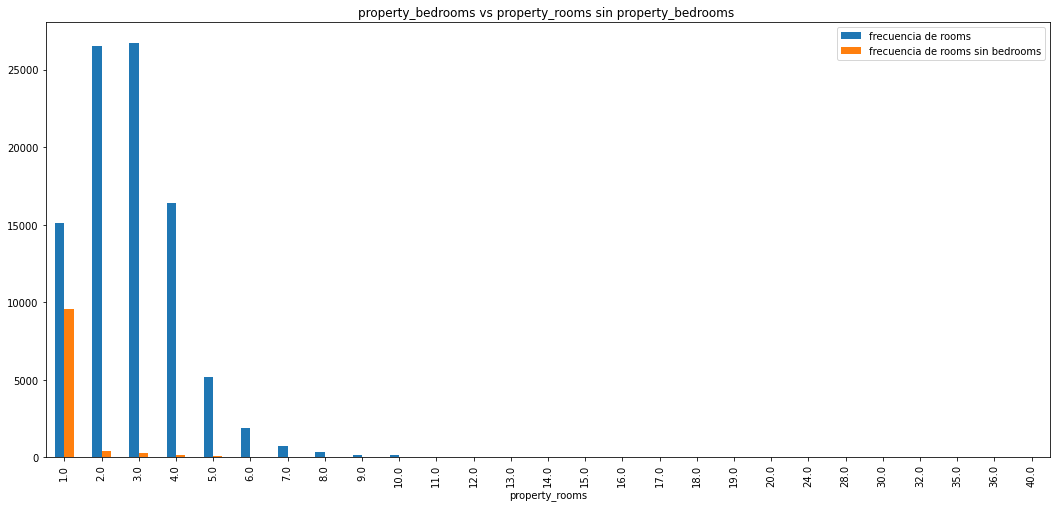

In [ ]:
temp_sin_bedrooms = ds_filtrado[ds_filtrado.property_bedrooms.isna()]

plotdata = pd.DataFrame({
    "frecuencia de rooms":ds_filtrado.property_rooms.value_counts(),
    "frecuencia de rooms sin bedrooms":temp_sin_bedrooms.property_rooms.value_counts(),
    }, 
)

plotdata.plot(kind="bar", figsize=(18,8))
plt.title("property_bedrooms vs property_rooms sin property_bedrooms ")
plt.xlabel("property_rooms")

Del grafico se puede analizar que en la vasta mayoria de los casos donde falta el dato sobre la cantidad de habitaciones es mayoritariamente en el caso de que se trate de monoambientes.

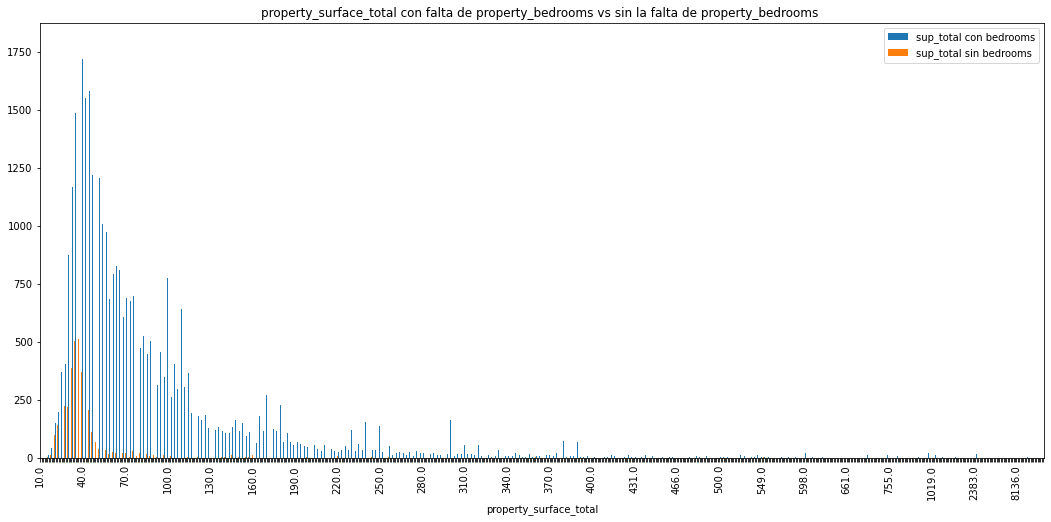

In [ ]:
temp_sin_bedrooms = ds_filtrado[ds_filtrado.property_bedrooms.isna()]

plotdata = pd.DataFrame({
    "sup_total con bedrooms":ds_filtrado.property_surface_total.value_counts(),
    "sup_total sin bedrooms":temp_sin_bedrooms.property_surface_total.value_counts(),
    }, 
)
plot_ = plotdata.plot(kind="bar", figsize=(18,8))
plt.title("property_surface_total con falta de property_bedrooms vs sin la falta de property_bedrooms ")
plt.xlabel("property_surface_total")

for ind, label in enumerate(plot_.get_xticklabels()):
    if ind % 30 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)

En este grafico se puede observar que la mayoria de los registros en donde falta property_bedrooms es en las propiedades con superficie mas chica, fortaleciendo asi la hipótesis de que se encuentra una falta de datos en la columna de cantidad de habitaciones al tratarse de monoambientes. 


In [ ]:
ds_filtrado[(ds_filtrado['property_rooms']==1)].property_bedrooms.value_counts()

1.0     5499
2.0       28
32.0       1
11.0       1
4.0        1
5.0        1
3.0        1
Name: property_bedrooms, dtype: int64


<font color='red'>los valores atípicos serán tratados en su respectiva sección</font> 


Dado que tener más de 1 habitación en un monoambiente es incoherente, y que la vasta mayoría de los monoambientes que no tienen dato faltante en propert_bedrooms tienen su valor en 1, reemplazamos lo registros monoambientes faltantes con 1 (asumiendo el supuesto de que las propiedades analizadas son hogares). 

Para los casos donde no son monoambientes, cuando predigamos la cantidad de habitaciones, reemplazaremos los 0's por 1's de igual manera mediante el mismo razonamiento. 

In [ ]:
columnas = ['property_rooms','property_bedrooms']
ds_property_bedrooms_sin_nan = ds_filtrado[columnas].copy()
cond_monoambiente = ds_property_bedrooms_sin_nan['property_rooms']==1
cond_bedroom_nan = ds_property_bedrooms_sin_nan['property_bedrooms'].isna()
ds_property_bedrooms_sin_nan.loc[cond_monoambiente & cond_bedroom_nan, 'property_bedrooms'] = 1 # reemplazamos monoambientes con bedrooms nan por 1


In [ ]:
print('El porcentaje de viviendas con mas de un ambiente (property_rooms) que no tienen habiaciones (property_bedrooms) es:', ds_filtrado['property_bedrooms'].isna().sum()/filas_totales*100)

El porcentaje de viviendas con mas de un ambiente (property_rooms) que no tienen habiaciones (property_bedrooms) es: 11.199057814937028


Por lo tanto, la mayoría de los casos en los cuales faltan habitaciones (property_bedrooms) es en monoambientes. Con lo cual, podemos asumir que los datos faltantes de esta variable son de tipo MAR. 

Para los casos donde se tiene mas de un ambiente, podemos aplicar el imputador iterativo. 

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression

columnas=['property_surface_total','property_surface_covered','property_bedrooms','property_rooms']
df_eliminar_nans_en_bedrooms_y_rooms = ds_filtrado[columnas].copy()

lr = LinearRegression()
imp = IterativeImputer(estimator=lr,missing_values=np.nan, max_iter=20, verbose=0, random_state=2) #imputation_order='roman'
array_sin_nans_en_bedrooms_y_rooms = imp.fit_transform(df_eliminar_nans_en_bedrooms_y_rooms)

In [ ]:
ds_sin_nans_en_bedrooms_y_rooms = pd.DataFrame(array_sin_nans_en_bedrooms_y_rooms, columns = columnas) #imp.fit_transfor devuelve un arrar sin nans en las columnas
ds_sin_nans_en_bedrooms_y_rooms = ds_sin_nans_en_bedrooms_y_rooms.round(0)

Text(0.5, 0, 'property_bedrooms')

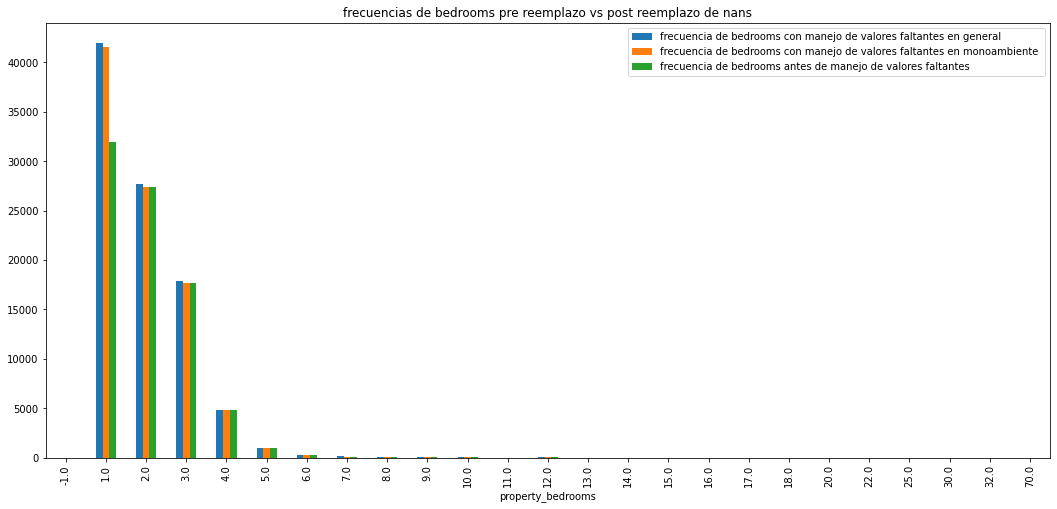

In [ ]:
plotdata = pd.DataFrame({
    "frecuencia de bedrooms con manejo de valores faltantes en general":ds_sin_nans_en_bedrooms_y_rooms.property_bedrooms.value_counts(),
    "frecuencia de bedrooms con manejo de valores faltantes en monoambiente ":ds_property_bedrooms_sin_nan.property_bedrooms.value_counts(),
    "frecuencia de bedrooms antes de manejo de valores faltantes":ds_filtrado.property_bedrooms.value_counts(),
    }, 
)

plotdata.plot(kind="bar", figsize=(18,8))
plt.title("frecuencias de bedrooms pre reemplazo vs post reemplazo de nans")
plt.xlabel("property_bedrooms")

In [ ]:
print("Porcentaje de valores nan en property_bedrooms antes de manejar los valores faltantes:", ds_filtrado['property_bedrooms'].isna().sum()/filas_totales*100)

ds_filtrado['property_bedrooms'] = ds_property_bedrooms_sin_nan['property_bedrooms']
ds_filtrado.loc[:,"property_bedrooms"].replace(to_replace=[ds_filtrado['property_bedrooms']],value=[ds_sin_nans_en_bedrooms_y_rooms['property_bedrooms']],inplace=True)

print("Porcentaje de valores nan en property_bedrooms despues de manejar los valores faltantes:", ds_filtrado['property_bedrooms'].isna().sum()/filas_totales*100)

Porcentaje de valores nan en property_bedrooms antes de manejar los valores faltantes: 11.199057814937028
Porcentaje de valores nan en property_bedrooms despues de manejar los valores faltantes: 0.0


#### Latitud y Longitud

Analizaremos estos dos datos juntos dado que tienen una relación lógica y tienen además el mismo procentaje de nans

Primero analizamos si los registros que tienen nan en latitud son los mismos que tienen nan en longitud (y viceversa)

In [ ]:
cond_longitud_nan = ds_filtrado['longitud'].isna()
cond_latitud_nan = ds_filtrado['latitud'].isna()
print(ds_filtrado[cond_longitud_nan].shape)
print(ds_filtrado[cond_latitud_nan].shape)
print(ds_filtrado[cond_longitud_nan & cond_latitud_nan].shape)

(3666, 20)
(3666, 20)
(3666, 20)


Observamos que los registros que tienen alguno de los dos datos faltantes, también tiene su par faltante. Con lo cual, tiene analizarlos juntos. Ahora analizaremos si los registros con estos datos faltantes corresponden a un barrio en específico, o si tienen alguna relación con la columna de barrio en general.

In [ ]:
registros_sin_coord = ds_filtrado[cond_longitud_nan & cond_latitud_nan]
registros_sin_coord.place_l3.value_counts()

Palermo                 904
Belgrano                648
Nuñez                   229
Recoleta                227
Barrio Norte            182
Caballito               170
Almagro                 160
Villa Urquiza           150
Villa Crespo            111
Flores                  111
San Telmo                96
Balvanera                80
Puerto Madero            69
San Nicolás              46
Congreso                 39
Once                     33
Tribunales               32
Monserrat                26
Retiro                   18
Constitución             14
Barracas                 14
Abasto                   12
Paternal                 10
Colegiales               10
Saavedra                  9
Liniers                   9
Villa del Parque          9
Floresta                  8
Mataderos                 7
Parque Chacabuco          7
San Cristobal             7
Villa Devoto              7
Villa Pueyrredón          5
Coghlan                   5
Villa Lugano              4
Pompeya             

Buscamos ahora cuantos registros no tienen ningún valor respecto a la ubicación:

In [ ]:
cond_barrio_nan = ds_filtrado['place_l3'].isna()
cond_sector_barrial_nan = ds_filtrado['place_l4'].isna()
registros_sin_ubi = ds_filtrado[cond_longitud_nan & cond_latitud_nan & cond_barrio_nan & cond_sector_barrial_nan]
registros_sin_ubi.shape

(169, 20)

Tendría sentido remover estos registros dado que no hay variables con uan relación suficientemente fuerte para poder predecir la ubicación a partir de los otros datos. 

In [ ]:
ds_filtrado.drop(registros_sin_ubi.index, inplace=True)

Debido a que latitud y longitud son variables utilizadas para representar una ubicacion en especifico, pensamos en utilizar place_l3 y place_l4 para predecir los valores faltantes siendo que estas tambien representan ubicaciones. Al ser ambas variables categoricas no es posible utilizarlas en <font color='red'>metodos que utilicen regresion lineal. </font> 
Por este motivo, decidimos solo utilizar para predecir el valor de las mismas a property_surface_total y property_price dado que el m^2 en una determinada ubicacion varia con respecto a el de otras. 


A continuacion vamos a hacer el proceso de imputacion de los datos faltantes de latitud y longitud, pero no lo haremos con las dos variables al simultaneo ya que al hacerlo por separado podemos obtener mejores resultados.

In [ ]:
ds_a_imputar= ds_filtrado.copy()

In [ ]:
columnas=['latitud', 'property_price', 'property_surface_total']
df_eliminar_nans_en_latitud = ds_a_imputar[columnas].copy()

imp = IterativeImputer(missing_values=np.nan, max_iter=20, verbose=0, random_state=2) #imputation_order='roman'
array_sin_nans_en_latitud = imp.fit_transform(df_eliminar_nans_en_latitud)

In [ ]:
ds_sin_nans_en_latitud = pd.DataFrame(array_sin_nans_en_latitud, columns = columnas) #imp.fit_transfor devuelve un arrar sin nans en las columnas
ds_a_imputar.loc[:,"latitud"].replace(to_replace=[ds_a_imputar['latitud']],value=[ds_sin_nans_en_latitud['latitud']],inplace=True)

In [ ]:
columnas=['latitud','longitud', 'property_price', 'property_surface_total']
df_eliminar_nans_en_latitud_y_longitud = ds_a_imputar[columnas].copy()

array_sin_nans_en_latitud_y_longitud = imp.fit_transform(df_eliminar_nans_en_latitud_y_longitud)

In [ ]:
ds_sin_nans_en_latitud_y_longitud = pd.DataFrame(array_sin_nans_en_latitud_y_longitud, columns = columnas) #imp.fit_transfor devuelve un arrar sin nans en las columnas
ds_a_imputar.loc[:,"longitud"].replace(to_replace=[ds_a_imputar['longitud']],value=[ds_sin_nans_en_latitud_y_longitud['longitud']],inplace=True)

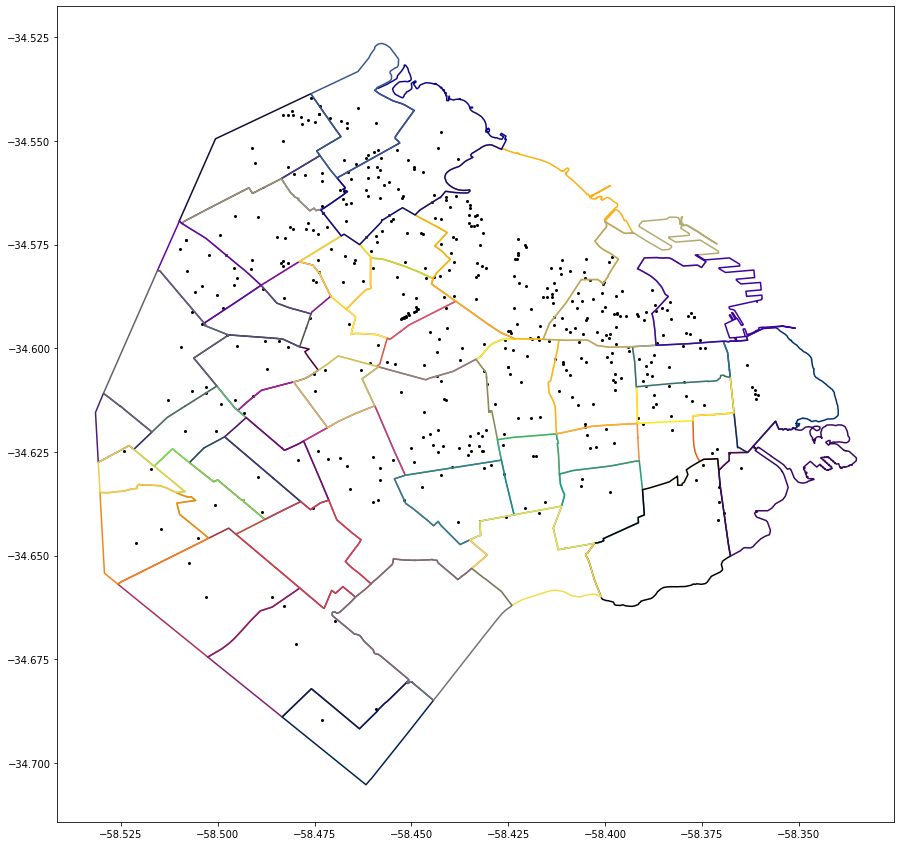

El porcentaje de outsiders dentro de la proporcion pedida de la muestra es: 0.4273504273504274


In [ ]:
#accedemos a los indices de las filas que tienen nans
filas=ds_a_imputar[ds_filtrado['longitud'].isna()].index

graficar_puntos_en_caba(ds_sin_nans_en_latitud_y_longitud.longitud, ds_sin_nans_en_latitud_y_longitud.latitud, proporcion=0.005)

In [ ]:
#ACA HAY QUE VER SI LAS COORDENADAS QUE PREDIJO EL ALGORITMO PERTENECEN AL PLACE L3 DE LA FILA CORRESPONDIENTE

LUEGO COMPLETAR EL DS_FILTRADO

####place_l3

In [ ]:
print("cantidad de registros place_l3 nulos:", ds_filtrado.place_l3.isna().sum())

cantidad de registros place_l3 nulos: 247


In [ ]:
cond_barrio_nan = ds_filtrado['place_l3'].isna()
# cond_sector_barrial_nan = ds_filtrado['place_l4'].isna()
registros_sin_ubi = ds_filtrado[cond_barrio_nan]
registros_sin_ubi.shape

(247, 20)

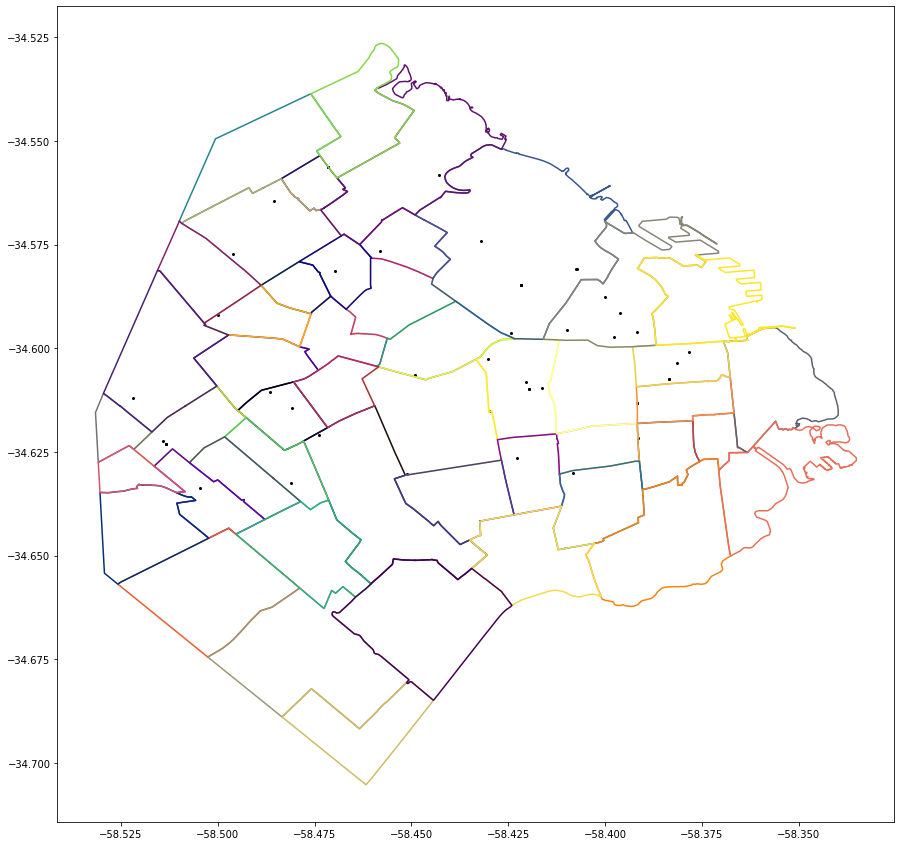

El porcentaje de outsiders dentro de la proporcion pedida de la muestra es: 79.35222672064778


In [ ]:
graficar_puntos_en_caba(registros_sin_ubi.longitud, registros_sin_ubi.latitud, proporcion=1)

Observando las latitudes y longitudes de los registros de los cuales place_l3 sus valores son nan, notamos que sus respectivas coordenadas se encuentran fuera de los limites de Capital Federal. Acontinuacion analizaremos como manejar estas incongruencias.

<font color='red'>CREEMOS QUE EL 80% QUE NO ESTA EN CABA HAY QUE ELIINARLO PERO TENEMOS QUE JUSTIFICAR BIEN. EL 20% QUE ESTA EN CABA HAY QUE, EN BASE A LA LAT Y LONG DETERMINAR EL PLACE_L3 MEDIANTE EL GRAFIQUITO. LUCIANO DIBUJE MAESTRO.</font> 

####property_rooms

In [ ]:
print("Cantidad de valores faltantes de property_rooms:",ds_filtrado['property_rooms'].isna().sum())

Cantidad de valores faltantes de property_rooms: 583


Como property_rooms esta fuertemente correlacionado con property_bedrooms utilizamos los mismos datos obtenidos en el manejo de valores faltantes de property_bedrooms para imputar los datos faltantes de porperty_rooms. Para ello utilizamos el dataset generado anteriormente en la seccion property_bedrooms.

Text(0.5, 0, 'property_rooms')

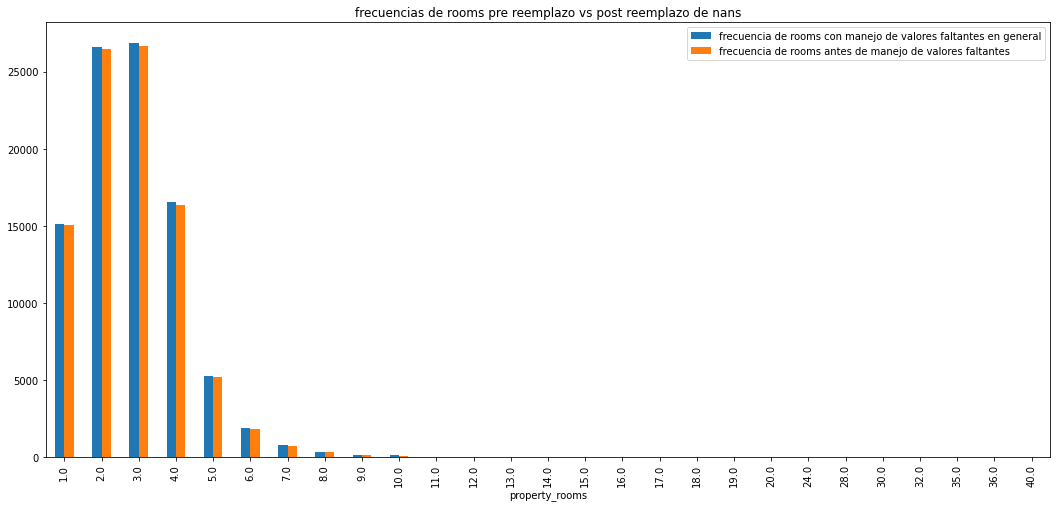

In [ ]:
plotdata = pd.DataFrame({
    "frecuencia de rooms con manejo de valores faltantes en general":ds_sin_nans_en_bedrooms_y_rooms.property_rooms.value_counts(),
    "frecuencia de rooms antes de manejo de valores faltantes":ds_filtrado.property_rooms.value_counts(),
    }, 
)

plotdata.plot(kind="bar", figsize=(18,8))
plt.title("frecuencias de rooms pre reemplazo vs post reemplazo de nans")
plt.xlabel("property_rooms")

In [ ]:
print("Porcentaje de valores nan en property_bedrooms antes de manejar los valores faltantes:", ds_filtrado['property_bedrooms'].isna().sum()/filas_totales*100)

ds_filtrado.loc[:,"property_rooms"].replace(to_replace=[ds_filtrado['property_rooms']],value=[ds_sin_nans_en_bedrooms_y_rooms['property_rooms']],inplace=True)

print("Porcentaje de valores nan en property_rooms despues de manejar los valores faltantes:", ds_filtrado['property_rooms'].isna().sum()/filas_totales*100)

Porcentaje de valores nan en property_bedrooms antes de manejar los valores faltantes: 0.0
Porcentaje de valores nan en property_rooms despues de manejar los valores faltantes: 0.0


####property_surface_total

Dado que property_surface_total y property_surfae_covered tienen una alta correlacion, analizamos los casos en los cuales ambas variables tiene valores nan.

In [ ]:
cond_superficie_total_nan = ds_filtrado['property_surface_total'].isna()
cond_superfice_cubierta_nan = ds_filtrado['property_surface_covered'].isna()
registros_sin_superficie_cubierta_ni_total = ds_filtrado[cond_superficie_total_nan & cond_superfice_cubierta_nan]
registros_sin_superficie_cubierta_ni_total.shape

(0, 20)

Como ningun registro tiene ambas variables con valor en nan, no eliminamos ningun registro. 

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression

columnas=['property_surface_total','property_surface_covered','property_rooms']
df_eliminar_nans_en_sup_total_y_cubierta = ds_filtrado[columnas].copy()

lr = LinearRegression()
imp = IterativeImputer(estimator=lr,missing_values=np.nan, max_iter=20, verbose=0, random_state=2) #imputation_order='roman'
array_sin_nans_en_sup_total_y_cubierta = imp.fit_transform(df_eliminar_nans_en_sup_total_y_cubierta)

In [ ]:
ds_sin_nans_en_sup_total_y_cubierta = pd.DataFrame(array_sin_nans_en_sup_total_y_cubierta, columns = columnas) #imp.fit_transfor devuelve un arrar sin nans en las columnas

<Figure size 432x288 with 0 Axes>

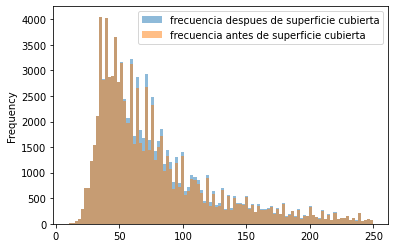

In [ ]:
ds_sin_nans_acotado = ds_sin_nans_en_sup_total_y_cubierta.query('property_surface_total < 250')
ds_filtrado_acotado = ds_filtrado.query('property_surface_total < 250')

#plotdata = pd.DataFrame({
#    "frecuencia despues de superficie cubierta":ds_sin_nans_en_sup_total_y_cubierta.property_surface_total.value_counts(),
#   "frecuencia antes de superficie cubierta":ds_filtrado.property_surface_total.value_counts(),
#    }, 
#)

plotdata = pd.DataFrame({
    "frecuencia despues de superficie cubierta":ds_sin_nans_acotado.property_surface_total,
   "frecuencia antes de superficie cubierta":ds_filtrado_acotado.property_surface_total,
    }, 
)

plt.figure()
plotdata.plot.hist(alpha=0.5, bins = 100)

Decidimos acotar los valores de los registros property_surface_total dado que observamos que con valores mayores a 250 la cantidad de regitros era minima y no se apreciaba completamente el grafico.  

In [ ]:
print("Porcentaje de valores nan en property_surface_total antes de manejar los valores faltantes:", ds_filtrado['property_surface_total'].isna().sum()/filas_totales*100)

ds_filtrado.loc[:,"property_surface_total"].replace(to_replace=[ds_filtrado['property_surface_total']],value=[ds_sin_nans_en_sup_total_y_cubierta['property_surface_total']],inplace=True)

print("Porcentaje de valores nan en property_surface_total despues de manejar los valores faltantes:", ds_filtrado['property_surface_total'].isna().sum()/filas_totales*100)

Porcentaje de valores nan en property_surface_total antes de manejar los valores faltantes: 4.978302157052064
Porcentaje de valores nan en property_surface_total despues de manejar los valores faltantes: 0.0


####property_surface_covered

Como property_surface_covered esta fuertemente correlacionado con property_surface_total utilizamos los mismos datos obtenidos en el manejo de valores faltantes de property_surface_total para imputar los datos faltantes de porperty_surface_covered. Para ello utilizamos el dataset generado anteriormente en la seccion property_surface_total.

<Figure size 432x288 with 0 Axes>

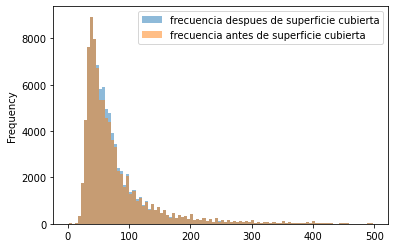

In [ ]:
ds_sin_nans_acotado = ds_sin_nans_en_sup_total_y_cubierta.query('property_surface_covered < 500')
ds_filtrado_acotado = ds_filtrado.query('property_surface_covered < 500')

plotdata = pd.DataFrame({
    "frecuencia despues de superficie cubierta":ds_sin_nans_acotado.property_surface_covered,
   "frecuencia antes de superficie cubierta":ds_filtrado_acotado.property_surface_covered,
    }, 
)

plt.figure()
plotdata.plot.hist(alpha=0.5, bins = 100)

#Ver grafico, sacamos el value_counts en pd.DataFrame

In [ ]:
print("Porcentaje de valores nan en property_surface_covered antes de manejar los valores faltantes:", ds_filtrado['property_surface_covered'].isna().sum()/filas_totales*100)

ds_filtrado.loc[:,"property_surface_covered"].replace(to_replace=[ds_filtrado['property_surface_covered']],value=[ds_sin_nans_en_sup_total_y_cubierta['property_surface_covered']],inplace=True)

print("Porcentaje de valores nan en property_surface_covered despues de manejar los valores faltantes:", ds_filtrado['property_surface_covered'].isna().sum()/filas_totales*100)

Porcentaje de valores nan en property_surface_covered antes de manejar los valores faltantes: 3.4971193328311174
Porcentaje de valores nan en property_surface_covered despues de manejar los valores faltantes: 0.0


##Valores Atípicos

###Detección de valores atípicos

####latitud y longitud

falta analizar latitud y longitud

####property_bedrooms

Realizamos un análisis sobre los posibles registros que podrían llegar a generar valores atípicos en  property_bedrooms. 

Debido a la alta correlación que tienen property_bedrooms y property_rooms, consideramos que property_rooms es el mejor candidato para determinar los valores atípicos de property_bedrooms. 

In [ ]:
# pd.crosstab(ds_filtrado.property_rooms, ds_filtrado.property_bedrooms) #es como una matriz, no me parece tan bueno dejarla

Viendo la tabla, pudimos visulizar que en caso de que la cantidad de ambientes sea menor a la cantidad de habitaciones, property_bedrooms seria un valor atipico.

Se puede visualizar que una gran cantidad de registros de property_bedrooms son valores atípicos ya que los valores de los mismos son mayores a los valores de los registros de property_rooms. 

Además, notamos que hay valores de property_bedrooms negativos, con lo cual esos valores también serían atípicos.

In [ ]:
cond_mas_bedrooms_que_rooms = ds_filtrado['property_bedrooms'] > ds_filtrado['property_rooms']

reg_mas_bed_que_rooms = ds_filtrado[cond_mas_bedrooms_que_rooms]
reg_mas_bed_que_rooms.shape

(16604, 20)

Como podemos observar hay 16604 registros de los cuales hay mas habitaciones en la propiedad que cantidad de ambientes, por lo tanto serian valores atipicos por lo que consideramos que hay que eliminarlos

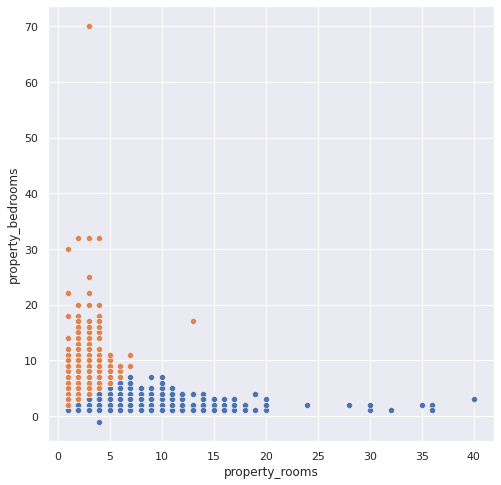

In [ ]:
# sns.set(rc={"figure.figsize":(8, 8)}) #aumenta el tamaño del grafico
sns.scatterplot(data = ds_filtrado, x = "property_rooms", y = "property_bedrooms")
sns.scatterplot(data = reg_mas_bed_que_rooms, x = "property_rooms", y = "property_bedrooms")#grafico de valores atipicos

In [ ]:
# ds_aux = ds_filtrado.drop(reg_mas_bed_que_rooms.index, inplace=False)# elimino las filas con mas bedrooms que rooms

In [ ]:
cond_bedrooms_menores_a_uno = ds_filtrado['property_bedrooms'] < 1
reg_con_bedrooms_menores_a_uno = ds_filtrado[cond_bedrooms_menores_a_uno]
reg_con_bedrooms_menores_a_uno.shape

(1, 20)

Observamos que solo un registro contiene una cantidad de bedrooms menor o igual a cero, por ese motivo consideramos que debe ser eliminado

In [ ]:
ds_filtrado.drop(reg_mas_bed_que_rooms.index, inplace=True)# elimino las filas con mas bedrooms menores a 1

####property_rooms

Por otro lado, tenemos los registros de property_rooms en donde sus valores son atípicos. Siguiendo la idea del gráfico anterior, consideramos que tener mas de 10 ambientes en un ph, departamento o casa es atípico (no es algo que suceda generalmente y es muy poco probable de que pase). 

Por otro lado, tener una gran cantidad de ambientes y muy poca cantidad de habitaciones (o ninguna) también sería  un valor atípico. 

In [ ]:
cond_rooms_menores_a_uno = ds_filtrado['property_rooms'] < 1
reg_con_rooms_menores_a_uno = ds_filtrado[cond_rooms_menores_a_uno]
reg_con_rooms_menores_a_uno.shape

(0, 20)

No hay rooms con valores negativos.

<font color='red'>QUE CONSIDERAMOS COMO MUCHOS AMBIENTES Y CUAL SERIA LA PROPORCION AMBIENTES-->HABITACIONES ???????????</font>

In [ ]:
cond_rooms_mayores_a_diez = ds_filtrado['property_rooms'] > 8
cond_bedrooms_menores_a_tres = ds_filtrado['property_bedrooms'] < 3
reg_con_rooms = ds_filtrado[cond_rooms_mayores_a_diez & cond_bedrooms_menores_a_tres]
reg_con_rooms.shape

(302, 20)

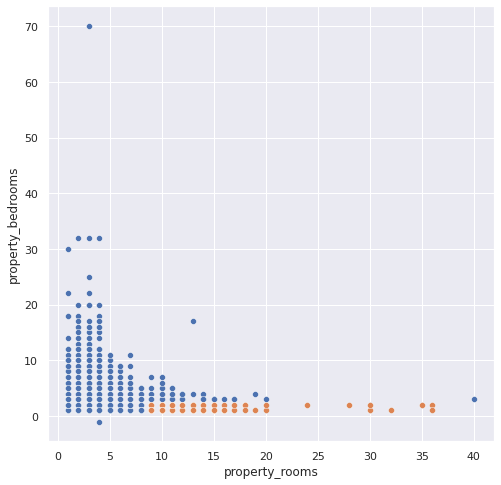

In [ ]:
sns.scatterplot(data=ds_filtrado, x="property_rooms", y="property_bedrooms")
sns.scatterplot(data=reg_con_rooms, x="property_rooms", y="property_bedrooms")